In [115]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Week 1

In [24]:
inflows = pd.read_parquet('../data/ucsd-inflows.pqt')
outflows = pd.read_parquet('../data/ucsd-outflows.pqt')

display(inflows.head(), outflows.head())

,prism_consumer_id,prism_account_id,memo,amount,posted_date,category
0,0,acc_0,PAYCHECK,2477.02,2022-03-18,PAYCHECK
1,0,acc_0,EXTERNAL_TRANSFER,100.00,2022-10-25,EXTERNAL_TRANSFER
2,0,acc_0,MISCELLANEOUS,6.29,2022-08-26,MISCELLANEOUS
3,0,acc_0,EXTERNAL_TRANSFER,277.00,2022-06-03,EXTERNAL_TRANSFER
4,0,acc_0,EXTERNAL_TRANSFER,100.00,2022-07-29,EXTERNAL_TRANSFER


,prism_consumer_id,prism_account_id,memo,amount,posted_date,category
0,0,acc_0,LOAN,900.60,2022-07-05,LOAN
1,0,acc_0,ATM_CASH,80.00,2022-03-25,ATM_CASH
2,0,acc_0,TST* Casa Del Rio - Exp Fairlawn OH 09/24,18.42,2022-09-26,FOOD_AND_BEVERAGES
3,0,acc_0,LOAN,634.00,2023-01-10,LOAN
4,0,acc_0,Buffalo Wild Wings,26.47,2022-09-12,FOOD_AND_BEVERAGES


In [25]:
outflows.posted_date = pd.to_datetime(outflows.posted_date)

I create a subset of `outflows` that doesn't include rows where `memo == category` because these are the rows that we train our model on to predict `category`.

In [4]:
outflows_with_memo = outflows[~(outflows.memo == outflows.category)].reset_index().drop(columns='index')
outflows_with_memo.head()

,prism_consumer_id,prism_account_id,memo,amount,posted_date,category
0,0,acc_0,TST* Casa Del Rio - Exp Fairlawn OH 09/24,18.42,2022-09-26,FOOD_AND_BEVERAGES
1,0,acc_0,Buffalo Wild Wings,26.47,2022-09-12,FOOD_AND_BEVERAGES
2,0,acc_0,Oculus CA 04/16,11.73,2022-04-18,GENERAL_MERCHANDISE
3,0,acc_0,LOS GIRASOLES STOW OH 03/08,30.04,2022-03-09,FOOD_AND_BEVERAGES
4,0,acc_0,BUZZIS LAUNDRY 1 OH 03/28,4.16,2022-03-29,GENERAL_MERCHANDISE


#### EDA

## WEEK 2 - Train Test Split

In [17]:
from sklearn.model_selection import train_test_split

#### Sample by consumer instead of transaction to avoid sampling bias

**From here on out, I only work with `outflows_with_memo` because that is the subset of the data we were told to work with.** This doesn't include rows where `memo == category`, and thereby includes rows that are pivotal to our prediction task.

In [18]:
def dataset_split(dataset):
    # get unique consumer ids
    ids = dataset.prism_consumer_id.unique()
    train_ids, test_ids = train_test_split(ids, test_size=0.25)

    # split customer_ids into train and test sets
    train = dataset[dataset['prism_consumer_id'].isin(train_ids)]
    test = dataset[dataset['prism_consumer_id'].isin(test_ids)]

    return train, test

In [7]:
outflows_memo_train, outflows_memo_test = dataset_split(outflows_with_memo)

For the subset of outflows that doesn't have the category given in the memo

In [8]:
print(f'# of unique IDS: {len(outflows_with_memo.prism_consumer_id.unique())}, # of unique train IDS: {len(outflows_memo_train.prism_consumer_id.unique())}, # of unique test IDS: {len(outflows_memo_test.prism_consumer_id.unique())}')

# of unique IDS: 2952, # of unique train IDS: 2214, # of unique test IDS: 738


In [11]:
outflows_with_memo.describe().apply(lambda s: s.apply('{0:.5f}'.format))

,prism_consumer_id,amount,posted_date
count,1306452.00000,1306452.00000,1306452.00000
mean,3182.59410,53.89793,.5f
min,0.00000,0.00000,.5f
25%,1501.00000,9.00000,.5f
50%,3421.00000,19.47000,.5f
75%,4787.00000,42.58000,.5f
max,5943.00000,280171.35000,.5f
std,1801.11219,635.18547,nan


In [12]:
outflows_memo_train.describe().apply(lambda s: s.apply('{0:.5f}'.format))

,prism_consumer_id,amount,posted_date
count,983268.00000,983268.00000,983268.00000
mean,3165.28376,54.79010,.5f
min,0.00000,0.00000,.5f
25%,1437.00000,9.00000,.5f
50%,3384.00000,19.48000,.5f
75%,4828.00000,42.54000,.5f
max,5940.00000,279412.00000,.5f
std,1820.39865,659.81185,nan


In [13]:
outflows_memo_test.describe().apply(lambda s: s.apply('{0:.5f}'.format))

,prism_consumer_id,amount,posted_date
count,323184.00000,323184.00000,323184.00000
mean,3235.25978,51.18357,.5f
min,2.00000,0.00000,.5f
25%,1653.00000,9.00000,.5f
50%,3513.00000,19.45000,.5f
75%,4648.00000,42.68000,.5f
max,5943.00000,280171.35000,.5f
std,1740.06515,553.55676,nan


#### TODO include statistical tests to ensure distributions are similar

## WEEK 3 - Memo Cleaning

In [9]:
import re

In [10]:
outflows_with_memo.head()

,prism_consumer_id,prism_account_id,memo,amount,posted_date,category
0,0,acc_0,TST* Casa Del Rio - Exp Fairlawn OH 09/24,18.42,2022-09-26,FOOD_AND_BEVERAGES
1,0,acc_0,Buffalo Wild Wings,26.47,2022-09-12,FOOD_AND_BEVERAGES
2,0,acc_0,Oculus CA 04/16,11.73,2022-04-18,GENERAL_MERCHANDISE
3,0,acc_0,LOS GIRASOLES STOW OH 03/08,30.04,2022-03-09,FOOD_AND_BEVERAGES
4,0,acc_0,BUZZIS LAUNDRY 1 OH 03/28,4.16,2022-03-29,GENERAL_MERCHANDISE


#### Memo cleaning steps:
- did more complex preprocessing first 
    - lemmatizer? (might not be good for this because it could stem words it shouldn't
    - same thing for stop words
    - remove dates (regex search mm/yy) and location addresses
    - get rid of email addresses -- TODO 
    - trans 1 @ $1.00 -- TODO
- simple preprocessing
    - lowercase 
    - remove punctuation (,-*#_')
    - remove XXXX, even amount of X's
    - remove purchase authorized on
    - remove purchase, checkcard
- should not preprocess memos that are the same category

In [11]:
# memos[memos.str.contains('@')].values[:1000]

In [12]:
# # looking at 
# test = memos.str.replace(r'trans \d+ @ \$\d+\.\d{2}', 'testing', regex=True)
# test[(test.str.contains('@'))].values[:1000]

In [13]:
# memos[(memos.str.contains('@'))].values[:1000]

In [24]:
# my memo function
def clean_memos(memos):
    pattern_X = r'\b\w*x{2,}\w*\b'
    pattern_dates = r'\b(0[1-9]|1[0-2])(\/|-)[0-9]{2}\b'
    pattern_special = r"[,'*#_-]"

    state_abbreviations = [
        "al", "ak", "az", "ar", "ca", "co", "ct", "de", "fl", "ga", 
        "hi", "id", "il", "in", "ia", "ks", "ky", "la", "me", "md", 
        "ma", "mi", "mn", "ms", "mo", "mt", "ne", "nv", "nh", "nj", 
        "nm", "ny", "nc", "nd", "oh", "ok", "or", "pa", "ri", "sc", 
        "sd", "tn", "tx", "ut", "vt", "va", "wa", "wv", "wi", "wy"
    ]
    pattern_state = r' (' + '|'.join(state_abbreviations) + r')\b'
    pattern_street = r'(street|st|road|rd|blvd|avenue|ave|highway|hwy)\b'

    cleaned_memos = (
        memos.str.lower()
            .str.replace(pattern_X, '', regex=True)                  # removing XXXX                        
            .str.replace(pattern_dates, '', regex=True)              # removing dates
            .str.replace(pattern_special, ' ', regex=True)            # removing unnecessary special characters
            .str.replace(r'~', ' ', regex=True)                       # removing ~ (can't include in character class above)
            .str.replace('purchase.* authorized on', '', regex=True) # removing common phrase
            .str.replace('checkcard', '')                            # removing common phrase
            .str.replace(pattern_state, '', regex=True)              # removing states
            .str.strip()
            .str.replace(pattern_street ,'', regex=True)
            .str.strip()
    )

    cleaned_memos = cleaned_memos.reset_index().drop(columns='index').squeeze()

    return cleaned_memos

In [20]:
# aman's memo function
def clean_memo(memo):
    sw = ['payment', 'transaction', 'deposit', 'withdrawal', 'transfer', 'credit', 'debit', 'refund', 'fee', 'charge', 'purchase', 'atm', 'checkcard']

    memo = memo.lower()

    memo = re.sub(r'[0-9]{3,}', '', memo) # remove instances of numbers more than 3 repeated
    
    memo = re.sub(r'x{3,}', '', memo) # remove the X's (ex. #XXXX)
    memo = re.sub(r'^#[a-z0-9]+', '', memo) # remove the #smth @ start of memo
    memo = re.sub(r'(www\.|\.com)', '', memo) # removing any links or urls

    memo = re.sub(r'[0-9x]{2}((-|/)[0-9x]{2,4}){1,2}', '', memo) # remove dates

    memo = re.sub(r'[^\w\s-]', ' ', memo)  # replace special characters with single space
    memo = re.sub(r'([a-z]+)\s{0,1}-\s{0,1}([a-z]+)', r'\1\2', memo) # replace '-' w/ ''
    memo = re.sub(r'\s+', ' ', memo)  # remove multiple spaces

    # location
    state_abbreviations = [
        "al", "ak", "az", "ar", "ca", "co", "ct", "de", "fl", "ga", 
        "hi", "id", "il", "in", "ia", "ks", "ky", "la", "me", "md", 
        "ma", "mi", "mn", "ms", "mo", "mt", "ne", "nv", "nh", "nj", 
        "nm", "ny", "nc", "nd", "oh", "ok", "or", "pa", "ri", "sc", 
        "sd", "tn", "tx", "ut", "vt", "va", "wa", "wv", "wi", "wy"
    ]
    state_pattern = r' (' + '|'.join(state_abbreviations) + r')\b'
    
    memo = re.sub(r'(street|st|road|rd|blvd|avenue|ave|highway|hwy)\b', '', memo)
    memo = memo.strip()
    memo = re.sub(state_pattern, '', memo)
    memo = memo.strip()

    merchant_map = {'wal walmart': 'walmart', 'walmart walmart': 'walmart', 'wal mart': 'walmart'}

    if memo in merchant_map: return merchant_map[memo]
    return memo

In [6]:
outflows_with_memo.head()

,prism_consumer_id,prism_account_id,memo,amount,posted_date,category
0,0,acc_0,TST* Casa Del Rio - Exp Fairlawn OH 09/24,18.42,2022-09-26,FOOD_AND_BEVERAGES
1,0,acc_0,Buffalo Wild Wings,26.47,2022-09-12,FOOD_AND_BEVERAGES
2,0,acc_0,Oculus CA 04/16,11.73,2022-04-18,GENERAL_MERCHANDISE
3,0,acc_0,LOS GIRASOLES STOW OH 03/08,30.04,2022-03-09,FOOD_AND_BEVERAGES
4,0,acc_0,BUZZIS LAUNDRY 1 OH 03/28,4.16,2022-03-29,GENERAL_MERCHANDISE


In [25]:
# replacing special characters with space
cleaned_memos_state_street = clean_memos(outflows_with_memo.memo)
cleaned_memos_state_street

0                             t  casa del rio   exp fairlawn
1                                         buffalo wild wings
2                                                     oculus
3                                         los girasoles stow
4                                           buzzis laundry 1
                                 ...                        
1306447    debit ca withdrawal purchaseamazon prime ti40l...
1306448    pos withdrawalaz lot quiktrip   e indian schoo...
1306449    pos withdrawalwal mart    e mckellips  mesa  c...
1306450    withdrawal salt river projetype: online pmt:sa...
1306451    pos withdrawalfrys food drg  1 435 s. e mesa  ...
Name: memo, Length: 1306452, dtype: object

In [23]:
outflows_with_memo.memo

0                  TST* Casa Del Rio - Exp Fairlawn OH 09/24
1                                         Buffalo Wild Wings
2                                            Oculus CA 04/16
3                                LOS GIRASOLES STOW OH 03/08
4                                  BUZZIS LAUNDRY 1 OH 03/28
                                 ...                        
1306447    DEBIT CARD WITHDRAWAL PURCHASEAmazon Prime*TI4...
1306448    POS WITHDRAWALAZ LOT QUIKTRIP XXXX XXXX E INDI...
1306449    POS WITHDRAWALWAL-MART #XXXX XXXX E MCKELLIPS ...
1306450    WITHDRAWAL Salt River ProjeTYPE: ONLINE PMT CO...
1306451    POS WITHDRAWALFRYS-FOOD-DRG #1 435 S. E MESA A...
Name: memo, Length: 1306452, dtype: object

In [18]:
cleaned_memos_state_street.iloc[-1]

'pos withdrawalfrysfooddrg 1 435 s. e mesa  ca 15   mcc'

In [136]:
outflows_with_memo['cleaned_memo'] = cleaned_memos

In [26]:
outflows_cleaned_state_street = outflows_with_memo.copy(deep=True)
outflows_cleaned_state_street['cleaned_memo'] = cleaned_memos_state_street

In [24]:
memos = outflows_with_memo.memo
cleaned_memos = outflows_with_memo.cleaned_memo
# cleaned_memos_aman = outflows_with_memo.aman_clean_memo

In [25]:
memos.unique().__len__(), cleaned_memos.unique().__len__(), #cleaned_memos_aman.unique().__len__(),

(528766, 307409)

In [27]:
# removing state and street suffix and replacing special characters with space resulted
# in more unique memos than just removing state and replacing special characters with empty character
cleaned_memos_state_street.unique().__len__()

304624

In [26]:
memos_counts = memos.value_counts()
cleaned_memos_counts = cleaned_memos.value_counts()
# cleaned_memos_aman_counts = cleaned_memos_aman.value_counts()

In [ ]:
z

In [27]:
memos_counts

memo
Amazon                                                                               31725
Walmart                                                                              31619
McDonald's                                                                           22670
Starbucks                                                                            12777
7-Eleven                                                                             11675
                                                                                     ...  
Doordash Kazu Sushi Bu                                                                   1
Par Gators Dockside -                                                                    1
Chilis Mandarin                                                                          1
Chilis Bay Meadows                                                                       1
POS WITHDRAWALWAL-MART #XXXX XXXX E MCKELLIPS RD MESA AZ  Card 15 #XXXX  MCC XXXX    

In [28]:
cleaned_memos_counts

cleaned_memo
walmart                                                          32099
amazon                                                           31737
mcdonalds                                                        27598
starbucks                                                        12823
7eleven                                                          11821
                                                                 ...  
lobby bar lake charles la  card                                      1
total wine and friendswood tx  card                                  1
victoria bridal houston tx  card                                     1
liquor hu  fm  baytown tx  card                                      1
pos withdrawalwalmart   e mckellips rd mesa az  card 15   mcc        1
Name: count, Length: 307409, dtype: int64

In [29]:
# cleaned_memos_aman_counts

In [30]:
counts = memos_counts.value_counts()[1:10]
cleaned_counts = cleaned_memos_counts.value_counts()[1:10]
# cleaned_aman_counts = cleaned_memos_aman_counts.value_counts()[1:10]

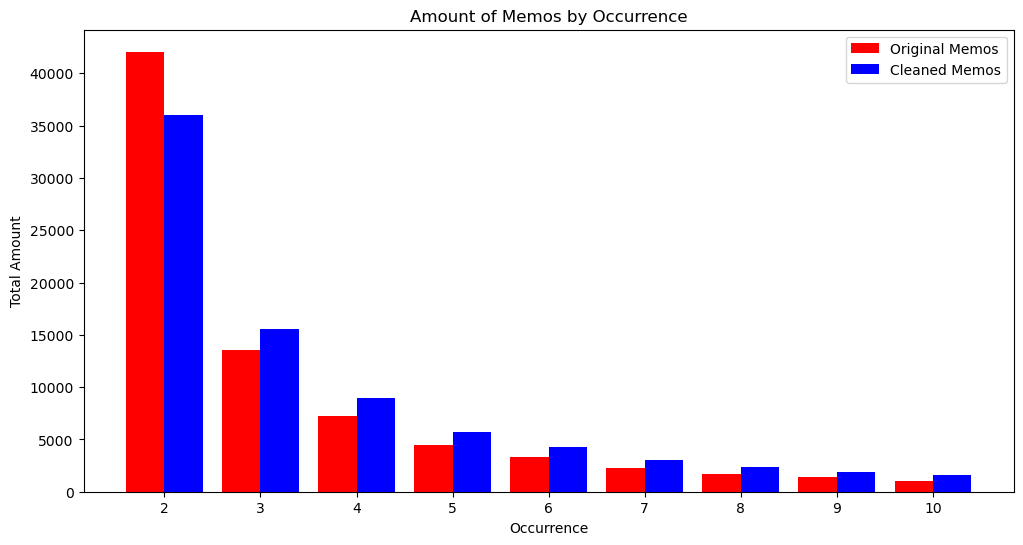

In [31]:
plt.figure(figsize=(12, 6))
plt.bar(counts.index - 0.2, counts.values, width=0.4, label='Original Memos', color='red')
plt.bar(cleaned_counts.index + 0.2, cleaned_counts.values, width=0.4, label='Cleaned Memos', color='blue')
# plt.bar(cleaned_aman_counts.index, cleaned_aman_counts.values, width=0.4, label='Cleaned Memos Aman', color='green')

plt.xlabel('Occurrence')
plt.ylabel('Total Amount')
plt.title('Amount of Memos by Occurrence')
plt.xticks(counts.index)
plt.legend()
plt.show()

In [32]:
(memos_counts == 1).sum()

443287

In [33]:
(cleaned_memos_counts == 1).sum()

214737

## Week 4

In [34]:
outflows_with_memo.head()

,prism_consumer_id,prism_account_id,memo,amount,posted_date,category,cleaned_memo
0,0,acc_0,TST* Casa Del Rio - Exp Fairlawn OH 09/24,18.42,2022-09-26,FOOD_AND_BEVERAGES,tst casa del rio exp fairlawn oh
1,0,acc_0,Buffalo Wild Wings,26.47,2022-09-12,FOOD_AND_BEVERAGES,buffalo wild wings
2,0,acc_0,Oculus CA 04/16,11.73,2022-04-18,GENERAL_MERCHANDISE,oculus ca
3,0,acc_0,LOS GIRASOLES STOW OH 03/08,30.04,2022-03-09,FOOD_AND_BEVERAGES,los girasoles stow oh
4,0,acc_0,BUZZIS LAUNDRY 1 OH 03/28,4.16,2022-03-29,GENERAL_MERCHANDISE,buzzis laundry 1 oh


### Creating Features

#### TF-IDF

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [29]:
def get_tfidf_features(dataset, max_features):
    cleaned_memos = dataset.cleaned_memo
    vectorizer = TfidfVectorizer(max_features=max_features)
    tfidf = vectorizer.fit_transform(cleaned_memos)
    
    tfidf_df = pd.DataFrame.sparse.from_spmatrix(tfidf)
    tfidf_df.columns = 'tfidf_' + vectorizer.get_feature_names_out()
    
    return tfidf_df

#### Dates and Amounts

**Date Features**
- month of year -- charges change by month (increase in food_and_beverages in summer, general_merchandise during holidays, travel)
- day of week -- charges change by day (weekend may see more food spending, weekday for groceries)
- day of month -- beginning of month charges (rent) vs middle of month charges (utilities) vs end of month (credit card?)

In [30]:
from sklearn.preprocessing import OneHotEncoder

In [31]:
def get_date_features(dataset):
    posted_date = dataset.posted_date
    date_features = pd.DataFrame()
    
    date_features['month'] = 'month_' + posted_date.dt.month.astype(str)
    date_features['weekday'] = 'weekday_' + posted_date.dt.weekday.astype(str)
    date_features['day_of_month'] = 'day_of_month_' + posted_date.dt.day.astype(str)

    date_enc = OneHotEncoder(drop='first', handle_unknown='ignore')
    date_one_hot = date_enc.fit_transform(date_features)

    date_columns = np.concatenate([feature[1:] for feature in date_enc.categories_])
    date_one_hot_df = pd.DataFrame.sparse.from_spmatrix(date_one_hot, columns=date_columns)

    return date_one_hot_df

**Amount Features**
- is even amount (x.00)
- bin the amounts based on size
    - potentially by category as well?

In [32]:
def get_amount_features(dataset):
    amount = dataset.amount

    amount_features = pd.DataFrame()
    amount_features['is_even'] = amount.apply(lambda x: 'amount_even' if x % 1 == 0 else 'amount_odd')
    amount_features['decile_amounts'] = pd.qcut(amount, q=10, labels=['decile_0', 'decile_1', 'decile_2', 'decile_3', 'decile_4', 'decile_5', 'decile_6', 'decile_7', 'decile_8', 'decile_9'])

    amount_enc = OneHotEncoder(drop='first', handle_unknown='ignore')
    amount_one_hot = amount_enc.fit_transform(amount_features)

    amount_columns = np.concatenate([feature[1:] for feature in amount_enc.categories_])
    amount_one_hot_df = pd.DataFrame.sparse.from_spmatrix(amount_one_hot, columns=amount_columns)
    
    return amount_one_hot_df

### Putting Features Together

In [20]:
def get_features_df(dataset, tfidf_max_features):
    tfidf_df = get_tfidf_features(dataset, tfidf_max_features)
    date_df = get_date_features(dataset)
    amount_df = get_amount_features(dataset)

    features_df =  pd.concat([tfidf_df, date_df, amount_df, dataset[['prism_consumer_id', 'category']]], axis=1)
    return features_df

In [21]:
def train_test_split_features(features_df):
    train_df, test_df = dataset_split(features_df)
    
    X_train = train_df.iloc[:, 8:]
    y_train = train_df['category']
    X_test = test_df.iloc[:, 8:]
    y_test = test_df['category']

    X_train.columns = X_train.columns.astype(str)
    X_test.columns = X_test.columns.astype(str)

    return X_train, y_train, X_test, y_test

In [22]:
# features df for memo with basic cleaning
# features_df = get_features_df(outflows_with_memo, tfidf_max_features=5000)
features_df = pd.read_pickle('../data/features_data.pkl')
X_train, y_train, X_test, y_test = train_test_split_features(features_df)

In [132]:
# features df for memo with basic cleaning + states removed
features_df_state = get_features_df(outflows_cleaned_state, tfidf_max_features=5000)
X_train, y_train, X_test, y_test = train_test_split_features(features_df_state)

In [43]:
# features df for memo with basic cleaning + states removed + streets removed + special characters replaced with space
features_df_state_street = get_features_df(outflows_cleaned_state_street, tfidf_max_features=5000)
X_train, y_train, X_test, y_test = train_test_split_features(features_df_state_street)

### Training Models

In [44]:
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
import seaborn as sns

#### Logistic Regression

In [45]:
def fit_model(X_train, y_train, model_type):
    if model_type == 'log_reg':
        model = LogisticRegression(max_iter=1000, random_state=0, n_jobs=-1).fit(X_train, y_train)
    elif model_type == 'xgboost':
        le = LabelEncoder()
        y_train_encoded = le.fit_transform(y_train)

        # hyperparameters to consider: n_estimators, max_depth, learning_rate
        model = XGBClassifier(objective='multi:softmax')
        model.fit(X_train, y_train_encoded)

        return model, le

    return model

In [46]:
def predict(X, y, model, le=None):
    if isinstance(model, LogisticRegression) or isinstance(model, LinearSVC):
        preds = model.predict(X)
    elif isinstance(model, XGBClassifier):
        preds_encoded = model.predict(X)
        preds = le.inverse_transform(preds_encoded)
    
    print(f"Accuracy: {(preds == y).mean():.3f}")
    
    return preds

In [47]:
# for i in range(len(coef_df)):
#     display(coef_df.iloc[i].abs().sort_values(ascending=False).iloc[:10])

**Accuracy by category**

In [48]:
def make_confusion_matrix(y, preds):
    conf_matrix = confusion_matrix(y, preds, labels=y.unique(), normalize='pred')
    classes = y.value_counts().sort_values(ascending=False).index
    conf_matrix_df = pd.DataFrame(conf_matrix, index=classes, columns=classes)

    fig, ax1 = plt.subplots(1, 1, figsize=(7, 7))
    
    sns.heatmap(conf_matrix_df, annot=True, fmt=".3f", cmap="YlGnBu", cbar=True, 
                linewidths=0.5, linecolor='gray', square=True, annot_kws={"size": 8}, ax=ax1)
    ax1.set_title('Precision')
    ax1.set_xlabel('Predicted Labels')
    ax1.set_ylabel('True Labels')

    plt.show()

In [51]:
%%time
# 500  tfidf  - 61 s - Train accuracy: 0.873, Test accuracy: 0.863
# 750  tfidf  - 62 s - Train accuracy: 0.895, Test accuracy: 0.889
# 1000 tfidf - 63 s - Train accuracy: 0.911, Test accuracy: 0.906
# 2000 tfidf - 66 s - Train accuracy: 0.938, Test accuracy: 0.927
# 3000 tfidf - 77 s - Train accuracy: 0.952, Test accuracy: 0.939
# 5000 tfidf - 68 s - Train accuracy: 0.964, Test accuracy: 0.946
log_reg = fit_model(X_train, y_train, 'log_reg')

CPU times: user 1.48 s, sys: 365 ms, total: 1.85 s
Wall time: 1min 6s


In [110]:
%%time
# 5000 tfidf - 75 s - Train accuracy: 0.961, Test accuracy: 0.941
log_reg_state = fit_model(X_train, y_train, 'log_reg')

CPU times: user 1.3 s, sys: 337 ms, total: 1.64 s
Wall time: 1min 15s


In [ ]:
%%time
# 5000 tfidf - 
log_reg_state_street = fit_model(X_train, y_train, 'log_reg')

In [ ]:
%%time
preds_train = predict(X_train, y_train, log_reg_state_street)

In [ ]:
%%time
preds_test = predict(X_test, y_test, log_reg_state_street)

In [54]:
# preds_train_aman = predict(X_train, y_train, log_reg)

In [55]:
# preds_test_aman = predict(X_test, y_test, log_reg)

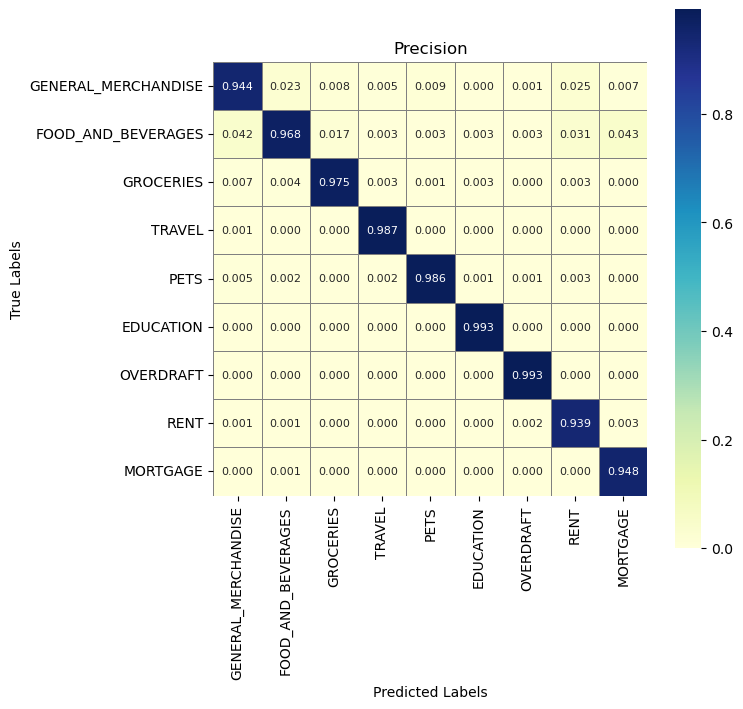

In [113]:
make_confusion_matrix(y_train, preds_train)

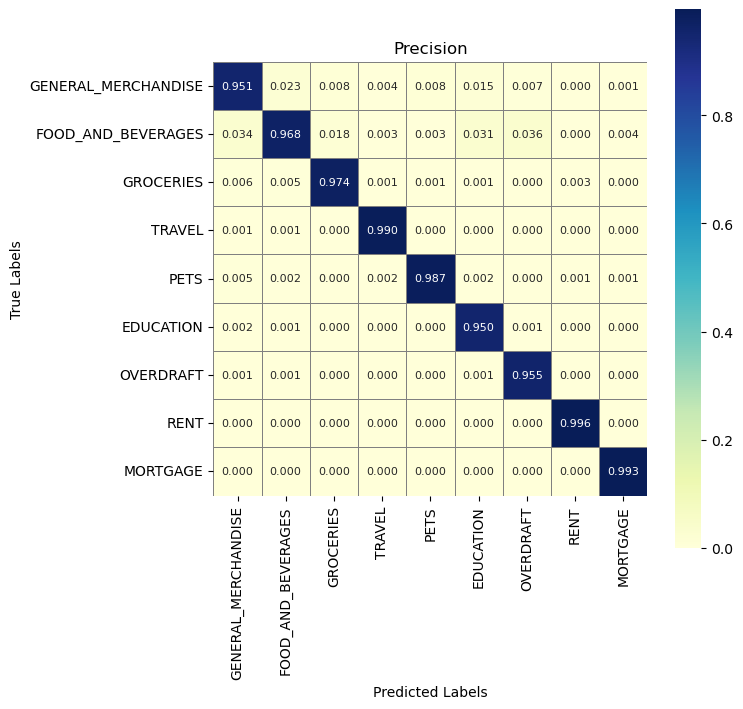

In [57]:
make_confusion_matrix(y_train, preds_train)

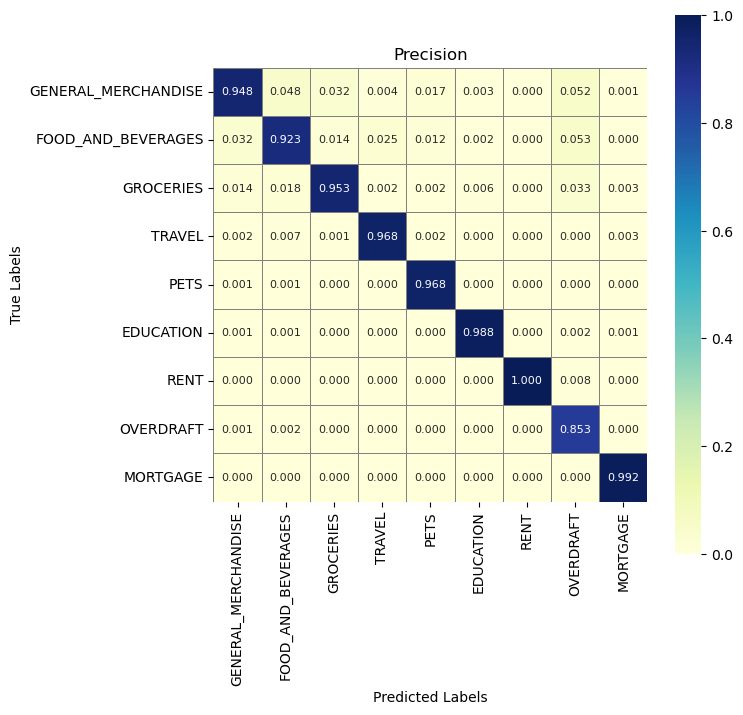

In [114]:
make_confusion_matrix(y_test, preds_test) # state 

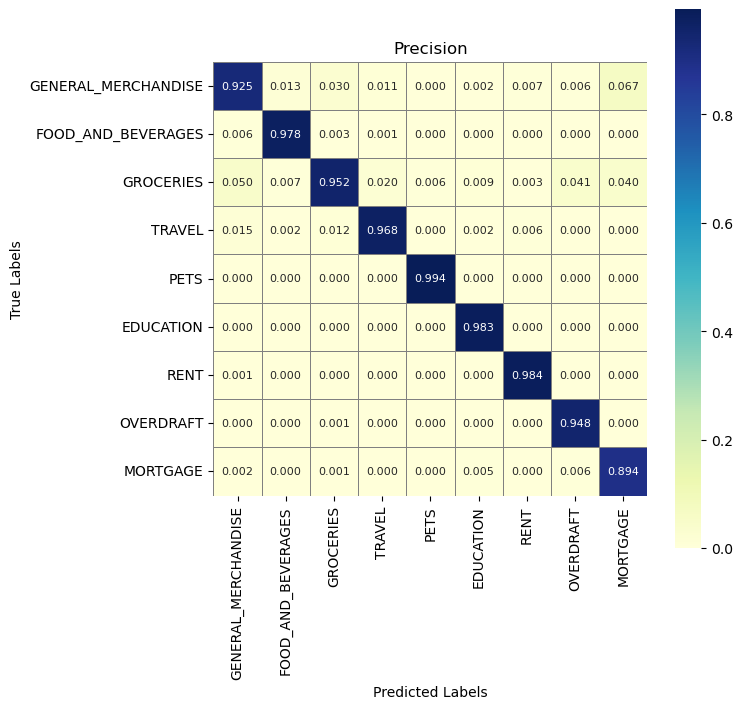

In [59]:
make_confusion_matrix(y_test, preds_test)
# the precision in Overdraft seems to perform the worst across models
# did it again with 5000 tfidf and it did good on overdraft but .894 on mortgage

In [ ]:
make_confusion_matrix(y_train, preds_train) # state street 

In [ ]:
make_confusion_matrix(y_test, preds_test) # state street

In [56]:
# make_confusion_matrix(y_train, preds_train_aman)

In [58]:
# make_confusion_matrix(y_test, preds_test_aman)

In [ ]:
bst, le = fit_model(X_train, y_train, 'xgboost')

In [ ]:
predict(X_train, y_train, bst, le)

In [ ]:
%%time

log_reg, preds_train, preds_test = fit_and_predict(X_train, y_train, X_test, y_test, model_type='log_reg')

In [ ]:
make_confusion_matrices(y_train, preds_train, y_test, preds_test)

#### Gradient Boosting (XGBoost)

In [39]:
# !pip install xgboost

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.9/153.9 MB 24.1 MB/s eta 0:00:0000:0100:01


In [ ]:
# 30ish seconds
bst, preds_train_bst, preds_test_bst = fit_and_predict(X_train, y_train, X_test, y_test, model_type='xgboost')

In [ ]:
# 'Train accuracy: 0.7301464661398314, Test accuracy: 0.7111407249466951' ------ basic xgboost w/ 50 features

In [ ]:
make_confusion_matrices(y_train, preds_train_bst, y_test, preds_test_bst)

In [ ]:
# testing how many tfidf features xgboost can handle
X_train, y_train, X_test, y_test = train_test_split_features(outflows_with_memo, tfidf_max_features=750)

In [ ]:
# 200 tfidf - 53 seconds - Train accuracy: 0.817, Test accuracy: 0.800
# 400 tfidf - 87 seconds - Train accuracy: 0.866, Test accuracy: 0.848
# 500 tfidf - 101 seconds - Train accuracy: 0.876, Test accuracy: 0.863
# 750 tfidf - 376 seconds - Train accuracy: 0.8941, Test accuracy: 0.882
bst, preds_train_bst, preds_test_bst = fit_and_predict(X_train, y_train, X_test, y_test, model_type='xgboost')

In [ ]:
make_confusion_matrices(y_train, preds_train_bst, y_test, preds_test_bst)

## Week 5

In [ ]:
# !pip install --upgrade transformers datasets evaluate accelerate

In [19]:
from transformers import AutoTokenizer
from transformers import DataCollatorWithPadding
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
import evaluate
import torch

2024-11-08 17:38:36.476944: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-08 17:38:36.477011: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-08 17:38:36.478841: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-08 17:38:36.490582: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [20]:
tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased")
accuracy = evaluate.load('accuracy')
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [21]:
unique_categories = outflows_with_memo.category.unique()
id2label = {i : unique_categories[i] for i in range(len(unique_categories))}
label2id = {unique_categories[i] : i for i in range(len(unique_categories))}

In [22]:
cleaned_memo_list = list(outflows_with_memo.cleaned_memo)
categories_encoded = [label2id[cat] for cat in outflows_with_memo.category]

In [23]:
X_train, X_test, y_train, y_test = train_test_split(cleaned_memo_list, categories_encoded, test_size=0.25)

In [24]:
X_train_tokenized = tokenizer(X_train, truncation=True, padding=True)
X_test_tokenized = tokenizer(X_test, truncation=True, padding=True)

In [25]:
class MemoDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [26]:
train_dataset = MemoDataset(X_train_tokenized, y_train)
test_dataset = MemoDataset(X_test_tokenized, y_test)

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [32]:
model = AutoModelForSequenceClassification.from_pretrained(
    'bert/checkpoint-7656', num_labels=9, id2label=id2label, label2id=label2id
).to(device)

In [33]:
# model = AutoModelForSequenceClassification.from_pretrained(
#     "distilbert/distilbert-base-uncased", num_labels=9, id2label=id2label, label2id=label2id
# ).to(device)

In [34]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [20]:
training_args = TrainingArguments(
    output_dir="bert",
    learning_rate=2e-5,
    per_device_train_batch_size=256,
    per_device_eval_batch_size=256,
    num_train_epochs=2,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=False,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    processing_class=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.072300,0.055678,0.982453
2,0.045100,0.045146,0.986433


TrainOutput(global_step=7656, training_loss=0.09350552859102047, metrics={'train_runtime': 7782.5855, 'train_samples_per_second': 251.803, 'train_steps_per_second': 0.984, 'total_flos': 3.650988561012778e+16, 'train_loss': 0.09350552859102047, 'epoch': 2.0})

In [36]:
# trainer.predict(test_dataset)

In [37]:
from transformers import TextClassificationPipeline

In [38]:
pipe = TextClassificationPipeline(model=model, tokenizer=tokenizer, device='cuda')

In [53]:
len(X_test)

326613

In [79]:
%%time
preds_train = pipe(X_train)
preds_train = [dct['label'] for dct in preds_train]

CPU times: user 1h 13min 56s, sys: 38.9 s, total: 1h 14min 35s
Wall time: 1h 14min 35s


In [78]:
%%time
# 677 ms for 100 predictions
# 4.73 s for 1000 predictions
# 46.2 s for 10000 predictions
# 8 min for test set in train step above
preds_test = pipe(X_test)
preds_test = [dct['label'] for dct in preds_test]

CPU times: user 25min 4s, sys: 13.7 s, total: 25min 18s
Wall time: 25min 18s


In [58]:
len(preds_test)

326613

In [59]:
%%time
pipe(X_test[0])

CPU times: user 9.51 ms, sys: 15.2 ms, total: 24.7 ms
Wall time: 23.6 ms


[{'label': 'GENERAL_MERCHANDISE', 'score': 0.9998961687088013}]

In [39]:
preds_test = pipe(X_test)
preds_test = [dct['label'] for dct in preds_test]

In [61]:
y_test_cats = [id2label[cat_id] for cat_id in y_test]
y_test_cats

['GENERAL_MERCHANDISE',
 'FOOD_AND_BEVERAGES',
 'GROCERIES',
 'GENERAL_MERCHANDISE',
 'FOOD_AND_BEVERAGES',
 'GENERAL_MERCHANDISE',
 'GENERAL_MERCHANDISE',
 'GENERAL_MERCHANDISE',
 'FOOD_AND_BEVERAGES',
 'GROCERIES',
 'GENERAL_MERCHANDISE',
 'FOOD_AND_BEVERAGES',
 'FOOD_AND_BEVERAGES',
 'GENERAL_MERCHANDISE',
 'FOOD_AND_BEVERAGES',
 'FOOD_AND_BEVERAGES',
 'GROCERIES',
 'GENERAL_MERCHANDISE',
 'GROCERIES',
 'GENERAL_MERCHANDISE',
 'FOOD_AND_BEVERAGES',
 'GENERAL_MERCHANDISE',
 'FOOD_AND_BEVERAGES',
 'FOOD_AND_BEVERAGES',
 'FOOD_AND_BEVERAGES',
 'FOOD_AND_BEVERAGES',
 'GROCERIES',
 'TRAVEL',
 'FOOD_AND_BEVERAGES',
 'GENERAL_MERCHANDISE',
 'GENERAL_MERCHANDISE',
 'GENERAL_MERCHANDISE',
 'FOOD_AND_BEVERAGES',
 'GENERAL_MERCHANDISE',
 'GENERAL_MERCHANDISE',
 'GROCERIES',
 'FOOD_AND_BEVERAGES',
 'GENERAL_MERCHANDISE',
 'GENERAL_MERCHANDISE',
 'GENERAL_MERCHANDISE',
 'PETS',
 'GENERAL_MERCHANDISE',
 'GENERAL_MERCHANDISE',
 'GROCERIES',
 'GROCERIES',
 'FOOD_AND_BEVERAGES',
 'FOOD_AND_BEVERAGES

In [63]:
# make_confusion_matrices(y_test=y_test_cats, preds_test=preds_test)

## Week 6

In [64]:
from sklearn.svm import LinearSVC

In [150]:
# parameters to mess around with: C, class_weight (class_weight bad)
svm = LinearSVC(C=0.5, dual='auto', random_state=0)

In [ ]:
%%time
# 5000 tfidf features, C=1.0, 2min 39s, Train accuracy: 0.964, Test Accuracy: 0.946
# 5000 tfidf features, C=0.5, 
svm.fit(X_train, y_train)

In [67]:
%%time
preds_train = predict(X_train, y_train, svm)

Accuracy: 0.964
CPU times: user 520 ms, sys: 202 ms, total: 721 ms
Wall time: 720 ms


In [68]:
%%time
preds_test = predict(X_test, y_test, svm)

Accuracy: 0.946
CPU times: user 336 ms, sys: 76 ms, total: 412 ms
Wall time: 411 ms


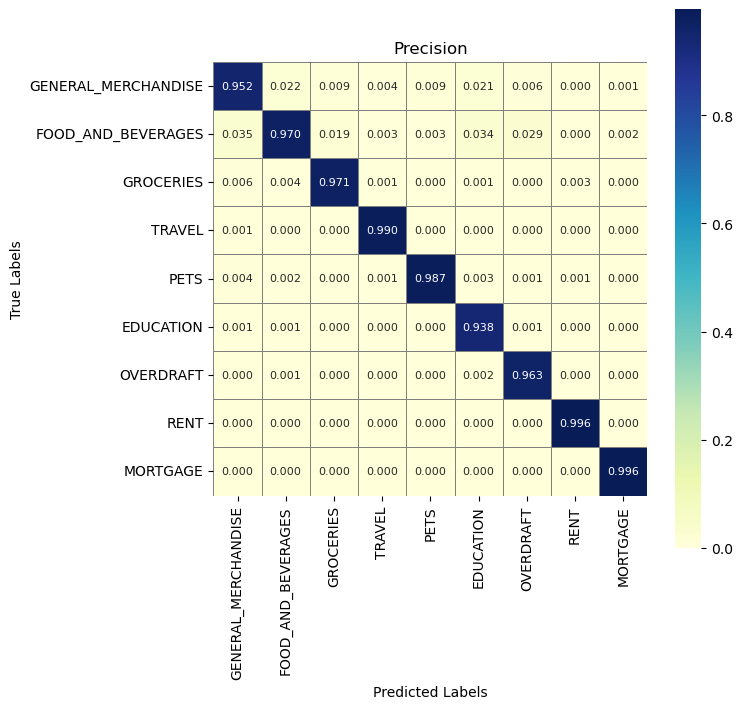

In [69]:
make_confusion_matrix(y_train, preds_train)

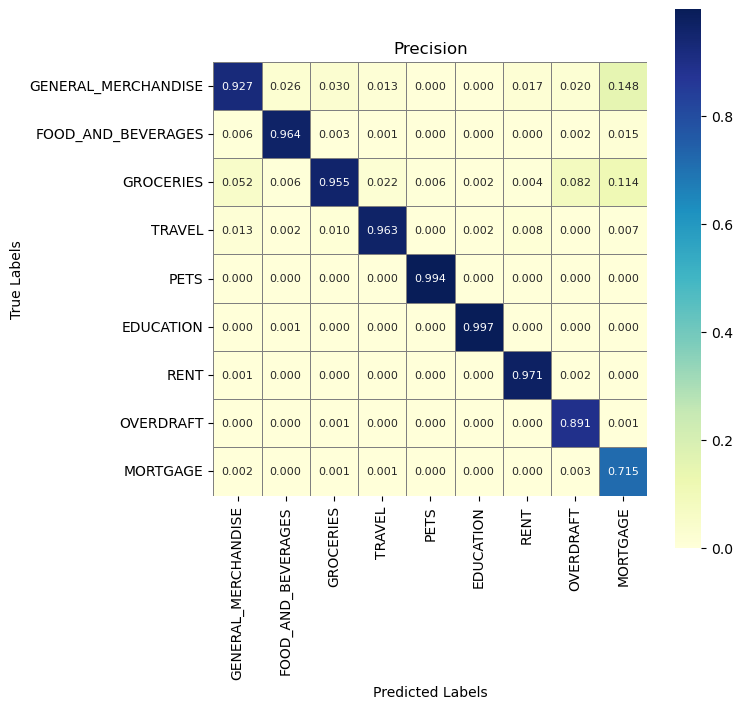

In [70]:
make_confusion_matrix(y_test, preds_test)
# may need to have some more regularization, overdraft doing worse than other categories in test set, 4000 tfidf features
# on 5000 tfidf features, overdraft is at 0.89 and mortgage is worse at 0.715

In [69]:
# balanced mode is very bad on the categories that don't appear that much
svm_balanced = LinearSVC(class_weight='balanced', dual='auto', random_state=0)

In [70]:
svm_balanced.fit(X_train, y_train)

LinearSVC(class_weight='balanced', dual='auto', random_state=0)

In [71]:
%%time
preds_train = predict(X_train, y_train, svm_balanced)

Accuracy: 0.950
CPU times: user 1.01 s, sys: 109 ms, total: 1.12 s
Wall time: 1.12 s


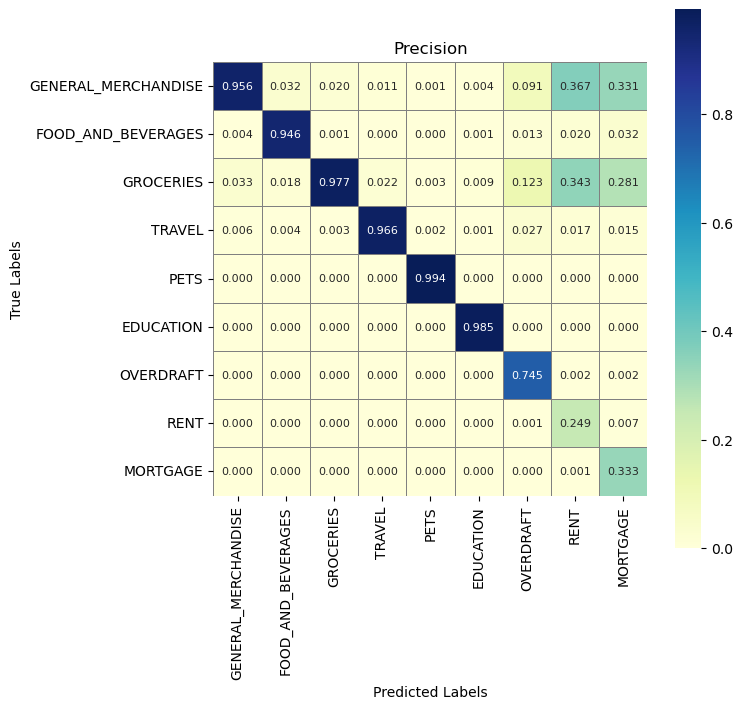

In [72]:
make_confusion_matrix(y_train, preds_train)

In [73]:
%%time
preds_test = predict(X_test, y_test, svm_balanced)

Accuracy: 0.929
CPU times: user 373 ms, sys: 23 ms, total: 396 ms
Wall time: 394 ms


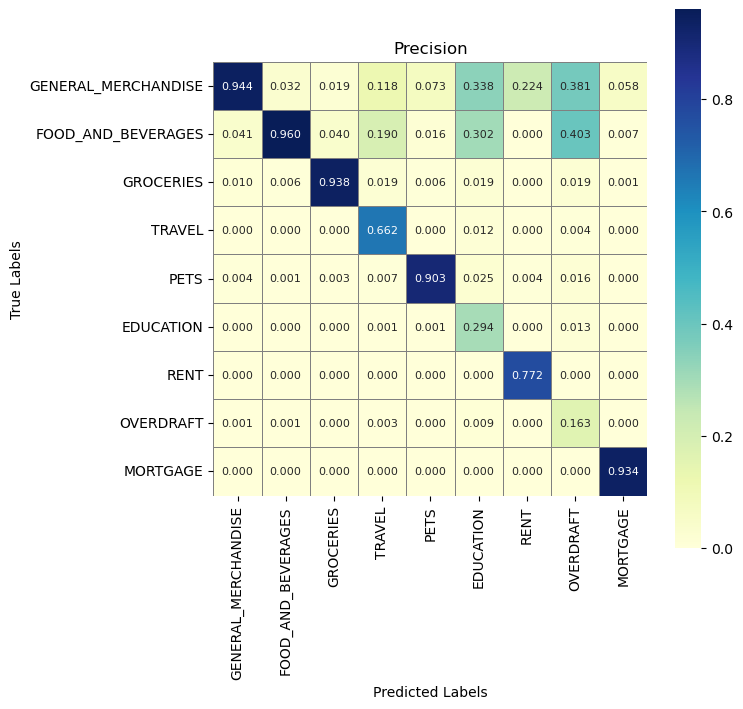

In [74]:
make_confusion_matrix(y_test, preds_test)
# may need to have some more regularization, overdraft doing worse than other categories in test set

## Week 7

In [34]:
# setting pandas df to display floats with 2 decimals
pd.options.display.float_format = '{:,.2f}'.format

In [26]:
inflows.head()

,prism_consumer_id,prism_account_id,memo,amount,posted_date,category
0,0,acc_0,PAYCHECK,2477.02,2022-03-18,PAYCHECK
1,0,acc_0,EXTERNAL_TRANSFER,100.00,2022-10-25,EXTERNAL_TRANSFER
2,0,acc_0,MISCELLANEOUS,6.29,2022-08-26,MISCELLANEOUS
3,0,acc_0,EXTERNAL_TRANSFER,277.00,2022-06-03,EXTERNAL_TRANSFER
4,0,acc_0,EXTERNAL_TRANSFER,100.00,2022-07-29,EXTERNAL_TRANSFER


In [27]:
# replacing category for PAYCHECK_PLACEHOLDER with PAYCHECK, effectively the same category
inflows.loc[inflows.category == 'PAYCHECK_PLACEHOLDER', 'category'] = 'PAYCHECK'

**Consumer-level statistics about inflows**
- Average inflow amount per consumer
- Total inflow amount per consumer
- Number of inflows per consumer

In [37]:
inflow_stats = inflows.groupby('prism_consumer_id')['amount'].agg(['mean', 'sum', 'count'])
inflow_stats.head()

,mean,sum,count
prism_consumer_id,,,
0,"1,212.22","110,312.43",91
2,"3,094.15","349,639.03",113
4,"3,043.14","462,557.90",152
7,"1,939.64","250,214.09",129
9,574.25,"215,342.01",375


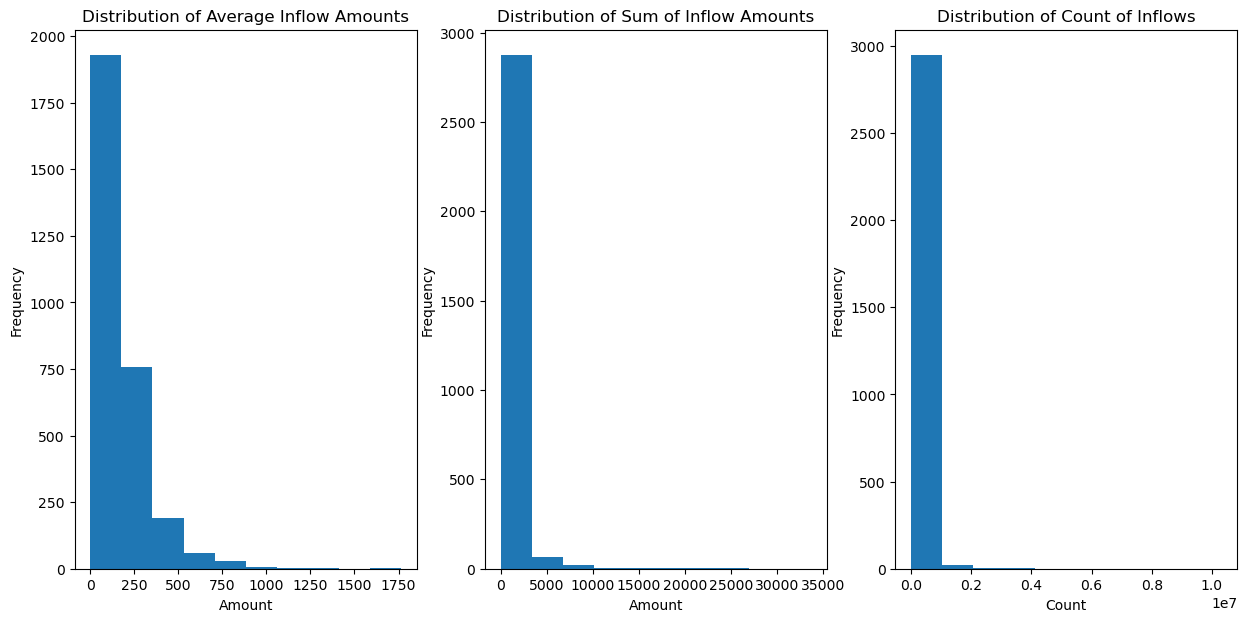

In [50]:
fig, ax = plt.subplots(1, 3, figsize=(15,7))

ax[0].hist(inflow_stats['count'])
ax[0].set_title('Distribution of Average Inflow Amounts')
ax[0].set_xlabel('Amount')
ax[0].set_ylabel('Frequency')

ax[1].hist(inflow_stats['mean'])
ax[1].set_title('Distribution of Sum of Inflow Amounts')
ax[1].set_xlabel('Amount')
ax[1].set_ylabel('Frequency')

ax[2].hist(inflow_stats['sum'])
ax[2].set_title('Distribution of Count of Inflows')
ax[2].set_xlabel('Count')
ax[2].set_ylabel('Frequency')

plt.show()

**What are the major sources of income?**

In [85]:
income_cats = ['EXTERNAL_TRANSFER', 'DEPOSIT', 'PAYCHECK', 'INVESTMENT_INCOME', 'OTHER_BENEFITS', 'UNEMPLOYMENT_BENEFITS']

In [86]:
income_inflows = inflows[inflows.category.isin(income_cats)]

In [109]:
inflows.shape, income_inflows.shape

((513115, 6), (304097, 6))

In [108]:
# across the entire dataset, sum and count of inflows
inflows.groupby('category')['amount'].agg(['sum', 'count']).sort_values(by='sum', ascending=False)

,sum,count
category,,
PAYCHECK,"89,724,682.02",59225
EXTERNAL_TRANSFER,"81,586,232.14",156533
DEPOSIT,"66,602,343.60",61345
MISCELLANEOUS,"52,594,312.59",55648
SELF_TRANSFER,"48,301,522.92",110437
OTHER_BENEFITS,"12,175,837.46",7708
INVESTMENT_INCOME,"6,887,278.35",17325
TAX,"5,619,601.78",3405
REFUND,"5,406,440.27",23220


In [111]:
# sum and count of inflows that are likely income
income_inflows.groupby('category')['amount'].agg(['sum', 'count']).sort_values(by='sum', ascending=False)

,sum,count
category,,
PAYCHECK,"89,724,682.02",59225
EXTERNAL_TRANSFER,"81,586,232.14",156533
DEPOSIT,"66,602,343.60",61345
OTHER_BENEFITS,"12,175,837.46",7708
INVESTMENT_INCOME,"6,887,278.35",17325
UNEMPLOYMENT_BENEFITS,"1,610,419.79",1961


Below, I get the top sources of income by breaking it down by consumer first, and then aggregating across the dataset. The rationale behind this is that while across the entire dataset, `PAYCHECK` and `EXTERNAL_TRANSFER` have the highest amounts, it might not be the case that for a single consumer, these are their major sources of income. So I find the top sources of income for each consumer, and then sum and count up those sources to get a better idea.

In [103]:
# getting top sources of income but retrieved by consumers rather than across the whole dataset, and then aggregated
def get_top_income_sources(inflows, num_sources=1):
    consumer_cat_amounts = inflows.groupby(['prism_consumer_id', 'category'], as_index=False)[['amount']].sum()
    consumer_cat_amounts_sorted = consumer_cat_amounts.sort_values(
                                    by=['prism_consumer_id', 'amount'], 
                                    ascending=[True, False]
                                ).reset_index(drop=True)
    return consumer_cat_amounts_sorted.groupby('prism_consumer_id').head(num_sources) \
                                      .groupby('category')['amount'].agg(['sum', 'count']) \
                                      .sort_values(by='sum', ascending=False)

In [112]:
# looking at the number 1 source of income for each consumer (number 1 determined by amount), it looks like PAYCHECK has the highest amount
# and occurs the most when looking at all inflows categories
get_top_income_sources(inflows)

,sum,count
category,,
PAYCHECK,"69,067,273.05",1274
EXTERNAL_TRANSFER,"48,663,260.43",431
DEPOSIT,"35,167,802.12",362
MISCELLANEOUS,"30,100,469.08",500
SELF_TRANSFER,"18,576,791.51",177
OTHER_BENEFITS,"6,401,265.55",156
INVESTMENT_INCOME,"1,323,765.04",12
REFUND,"885,897.16",34
UNEMPLOYMENT_BENEFITS,"269,033.73",5


In [105]:
# When looking at the top 3 sources of income, it is no longer as clear. EXTERNAL_TRANSFER now appears more than PAYCHECK, and is much closer in amount.
# DEPOSIT also went up considerably.
get_top_income_sources(inflows, 3)

,sum,count
category,,
PAYCHECK,"86,304,379.79",1851
EXTERNAL_TRANSFER,"76,788,728.05",1857
DEPOSIT,"60,582,600.50",1449
MISCELLANEOUS,"47,575,985.46",1241
SELF_TRANSFER,"44,456,725.60",1005
OTHER_BENEFITS,"10,754,831.79",329
INVESTMENT_INCOME,"4,162,584.62",168
REFUND,"2,992,197.57",269
TAX,"2,433,325.61",297


In [106]:
# When limiting the transactions to categories that can actually be income, each of the counts of categories went up because other categories were 
# removed, so they moved up in the list.
get_top_income_sources(income_inflows)

,sum,count
category,,
PAYCHECK,"75,400,428.27",1492
EXTERNAL_TRANSFER,"56,036,688.50",697
DEPOSIT,"40,166,199.84",536
OTHER_BENEFITS,"7,468,128.46",196
INVESTMENT_INCOME,"1,589,384.00",38
UNEMPLOYMENT_BENEFITS,"294,031.73",8


In [107]:
# As seen in the other comparison, EXTERNAL_TRANSFER and DEPOSIT occurs much more than PAYCHECK.
get_top_income_sources(income_inflows, 3)

,sum,count
category,,
PAYCHECK,"89,261,190.78",2121
EXTERNAL_TRANSFER,"80,938,789.15",2633
DEPOSIT,"65,802,733.55",2459
OTHER_BENEFITS,"11,724,800.36",397
INVESTMENT_INCOME,"6,023,017.70",556
UNEMPLOYMENT_BENEFITS,"1,367,898.02",76


These patterns can likely be explained by the nature of the categories. The fact that `PAYCHECK` still dominates in amount but begins to lose out in number of appearances to `EXTERNAL_TRANSFER` and `DEPOSIT` could be because direct deposit paychecks tend to be larger than external transfers like Venmo, Zelle, etc. They are larger because paychecks come from higher-paying jobs like in engineering and corporate but income coming from Venmo and Zelle are likely under the table jobs that don't get paid as much